In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class LanderNN(nn.Module):
    def __init__(self, input_dims, n_actions, lr):
        super(LanderNN, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(*self.input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions),
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

In [3]:
class Agent:
    def __init__(self, lr, input_dims, n_actions=4, gamma=0.99):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma

        self.reward_memory = []
        self.action_memory = []

        self.policy = LanderNN(
            input_dims=self.input_dims, n_actions=self.n_actions, lr=self.lr
        )

    def choose_action(self, state):
        # need to add batch dimension to state so pytorch doesn't freak out
        state = torch.Tensor(np.array(state)).to(self.policy.device)
        probs = F.softmax(self.policy(state), dim=-1)

        # build distribution over probabilities
        action_probs = torch.distributions.Categorical(probs)

        # sample action from distribution
        action = action_probs.sample()

        # calculate log prob of action
        log_prob = action_probs.log_prob(action)
        self.action_memory.append(log_prob)

        # dereference pytorch tensor (gym doesn't like torch tensors)
        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()
        Gt = np.zeros_like(self.reward_memory, dtype=np.float64)

        for i in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for j in range(i, len(self.reward_memory)):
                G_sum += discount * self.reward_memory[j]
                discount *= self.gamma
            Gt[i] = G_sum

        Gt = torch.Tensor(Gt).to(self.policy.device)

        loss = 0
        for g, logprob in zip(Gt, self.action_memory):
            loss += -g * logprob
        loss.backward()
        self.policy.optimizer.step()

        self.reward_memory = []
        self.action_memory = []

In [4]:
def plot_running_avg(scores):
    avg = np.zeros_like(scores)
    for i in range(len(scores)):
        avg[i] = np.mean(scores[max(0, i - 100) : i + 1])
    plt.plot(avg)
    plt.title("Running Average per 100 Games")
    plt.xlabel("Episode")
    plt.ylabel("Average Score")
    plt.grid(True)
    plt.show()

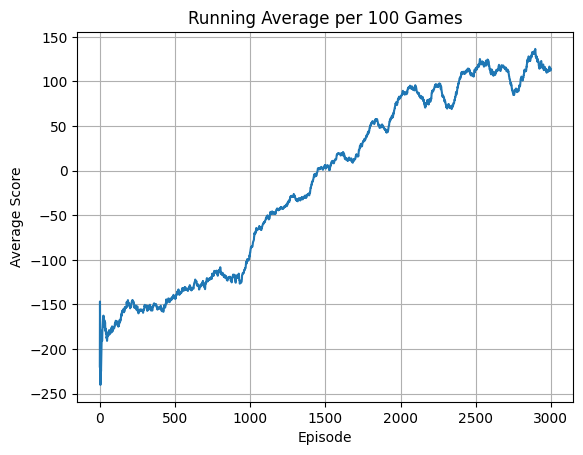

In [5]:
lr = 0.0005
n_games = 3000

env = gym.make("LunarLander-v2")
agent = Agent(lr=lr, input_dims=env.observation_space.shape)

scores = []
for i in range(n_games):
    print(f"Playing episode #{i+1}", end="\r")
    state, _ = env.reset()

    score = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = agent.choose_action(state)
        state_, reward, terminated, truncated, _ = env.step(action)
        agent.store_rewards(reward)
        score += reward
        state = state_

    agent.learn()
    scores.append(score)

plot_running_avg(scores)